# Data loader for Detectron2

In [ ]:
!ln -s ../contour_utils.py contour_utils.py

In [ ]:
import os
import json
import cv2
import random
import glob
import re
import logging
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, print_instances_class_histogram

import pydicom as dicom
from contour_utils import parse_dicom_image

In [ ]:
def get_detectron2_dicts(img_dir, modality, thing_classes, patient_keys=None):
    """
    Generate detectron2 formatted dict from dastaset
    For now create separate dataset dict for PT and CT images
    Inputs:
        img_dir (string): path to the dataset directory
        modality (string): 'PT' or 'CT'
        thing_classes (dict): mapping to go from ROI class to integer id
        patient_keys (list): optional arg to specify which patients to include in dataset dict
                             useful for train/validation/test split. If None then use all patients
    Returns:
        dataset_dicts (dict): formatted dataset dict
    """
    json_file = os.path.join(img_dir, "global_dict.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)
    
    # get all patient keys if None specified
    if not patient_keys:
        patient_keys = imgs_anns.keys()

    dataset_dicts = []
    total_patients = len(patient_keys)
    # iterate over each specified patient
    for idx, patient in enumerate(tqdm(patient_keys)):
        m = imgs_anns[patient][modality]
        all_frame_fp = glob.glob(m['fp'] + "/*.dcm")

        # iterate over each frame
        for jdx, frame_fp in enumerate(all_frame_fp):
            record = {}
            
            # get the slice number of dicom frame
            slice_num = int(re.findall(r'\d+', frame_fp)[-1])
            
            # get image array to get image width, height
            dcm = dicom.read_file(frame_fp)
            img_arr = parse_dicom_image(dcm)
            height, width = np.shape(img_arr)
            
            record["file_name"] = frame_fp
            record["image_id"] = idx * total_patients + jdx
            record["height"] = height
            record["width"] = width
            
            roi_keys = m['rois'].keys()
            objs = []
            
            # iterate over each ROI
            for _, roi in enumerate(roi_keys):
                # check for tumor, tumor2, tumor3 classes
                if "Tumor" in roi:
                    roi = "Tumor"
                    
                # skip if roi is not in thing_classes
                if roi not in thing_classes:
                    continue
                
                # get integer id for roi
                category_id = thing_classes[roi]
                contours = np.array(m['rois'][roi][slice_num])
                polys = []
                px = []
                py = []
                
                # iterate over each set of x,y polygon coordinates
                for item in contours:
                    item = np.array(item).astype(int)
                    # convert list of tuples to list e.g. [x1,y1,x2,y2]
                    # polys.append([*t for t in item]) # doesn't work
                    polys.append([int(val) for t in item for val in t])
                    px.extend(item[:,0])
                    py.extend(item[:,1])
                    
                if len(px) != 0:
                    obj = {
                        "bbox": [int(np.min(px)), int(np.min(py)),
                                 int(np.max(px)), int(np.max(py))],
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "segmentation": polys,
                        "category_id": category_id,
                    }
                    objs.append(obj)
        
            record["annotations"] = objs
            dataset_dicts.append(record)

    return dataset_dicts

In [ ]:
# specify name/path of dataset
img_dir = 'image_dataset'
# hacky fix, image_dataset is in root directory of repo
!ln -s ../image_dataset image_dataset

# define mapping for ROI classes
# NOTE: ignoring SUV Peak Sphere 1 and SUV Sphere 1 - SUV Sphere Max Value
# NOTE: doing instance segmentation so merge tumor classes tumor, tumor2, tumor3
thing_classes_dict = {'PT':{'Bladder':0,
                            'TURP urethra':1,
                            'Tumor':2},
                     'CT': {'Bladder':0,
                            'Inter':1,
                            'Threshold':2,
                            'L seminal':3,
                            'R seminal':4}}

# dict to store both datasets
dicts_all = {}
# register dataset into Detectron2 catalog, second arg needs to be a function
for modality in ['PT', 'CT']:
    dataset_name = "prostate_dataset_" + modality
    DatasetCatalog.register(dataset_name, lambda: get_detectron2_dicts(img_dir, modality))

    # set metadata for registered dataset
    # thing_classes is for instance segmentation while stuff_classes is for semantic
    # https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#metadata-for-datasets
    MetadataCatalog.get(dataset_name).thing_classes = list(thing_classes_dict[modality].keys())
    #MetadataCatalog.get(dataset_name).thing_colors = list(thing_classes.keys())
    metadata = MetadataCatalog.get(dataset_name)
    
    # get dastaset dicts so can visualize below
    dataset_dicts = get_detectron2_dicts(img_dir, modality, thing_classes_dict[modality])
    
    dicts_all[modality] = {'metadata': metadata,
                           'dicts': dataset_dicts}

In [ ]:
def register_dataset_dict(name, json_fp, metadata):
    """
    Register serialized json dataset dict to Detectron2 catalog
    Inputs:
        name (string): name to be given to the registered dataset
        json_fp (string): file path of the json file storing the dataset dict
        metadata (dict): metadata to store about the dataset
    """
    logger = logging.getLogger("detectron2.data")
    # check if dataset already exists
    if name not in DatasetCatalog.list():
        logger.info("Adding dataset '%s' to dataset catalog" % name)

        # register a function which returns dicts
        DatasetCatalog.register(name, lambda: json.load(open(json_fp)))

        # add dataset metadata
        MetadataCatalog.get(name).set(json_file=json_fp, **metadata)

    else:
        logger.warning("Dataset with name '%s' is already registered, ignoring...")

In [ ]:
# test method above which loads saved json file and registers dataset to catalog
for m in ["PT", "CT"]:
    register_dataset_dict("detectron2_dict_" + m, "detectron2_dict_" + m + ".json",
                          {"thing_classes": list(thing_classes_dict[m].keys())})

In [ ]:
# make plots bigger
plt.rcParams["figure.figsize"]=10,10

In [ ]:
def visualize_annotations(dataset_dicts, metadata, count=10, detectron2_visualizer=True):
    """
    Visualize annotations from processed dataset dict
    Can view annotations using either Detectron2 visualizer or manual method
    Inputs:
        dataset_dicts (dict): dict object returned by get_detectron2_dicts method
        metadata (dict): dataset metadata
        count (int): number of images to output
        detectron2_visualizer (boolean): if true then use Detectron2 visualizer
    """
    # init count for number of images
    c = 0
    # get random images until outputted images == count
    while c < count:
        d = random.sample(dataset_dicts, 1)[0]
        if len(d['annotations']) == 0:
            continue
        
        c += 1
        # show raw frame with no annotations
        dcm = dicom.read_file(d["file_name"])
        img = parse_dicom_image(dcm)
        plt.imshow(img)
        plt.show()
        
        if detectron2_visualizer:
            visualizer = Visualizer(img, metadata=metadata, scale=1.0)
            out = visualizer.draw_dataset_dict(d)
            plt.imshow(out.get_image())
            plt.show()
            
        else:
            # NOTE: only gets first annotation and segmentation
            annos = d['annotations'][0]['segmentation'][0]
            contours = np.zeros((d['width'], d['height']))
            indices = np.arange(0, len(annos), 2)
            for i in indices:
                # matrix element is indexed by first row number (y coord) then column number (x coord)
                contours[annos[i+1], annos[i]] = 1

            plt.imshow(contours)
            plt.show()

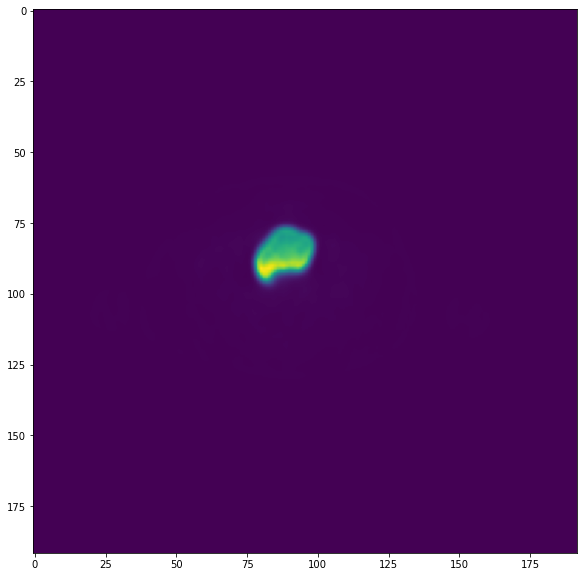

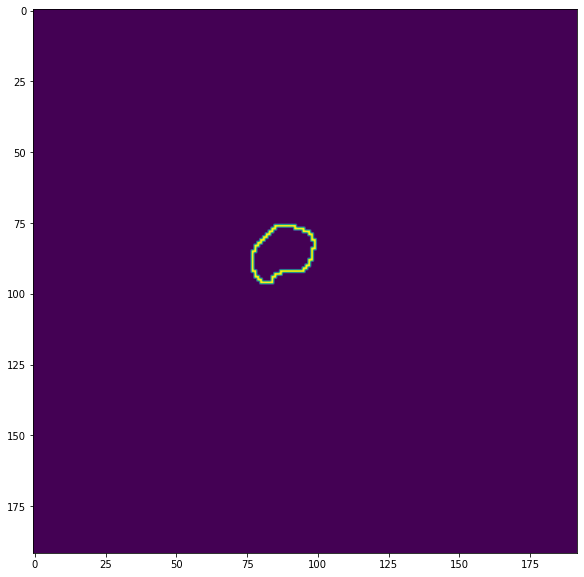

In [63]:
# visualize images + annotations from PT dataset
visualize_annotations(dicts_all['PT']['dicts'], dicts_all['PT']['metadata'], 1, False)

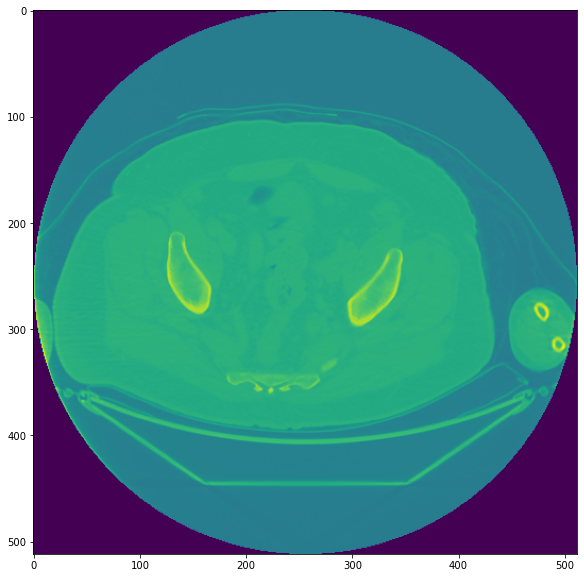

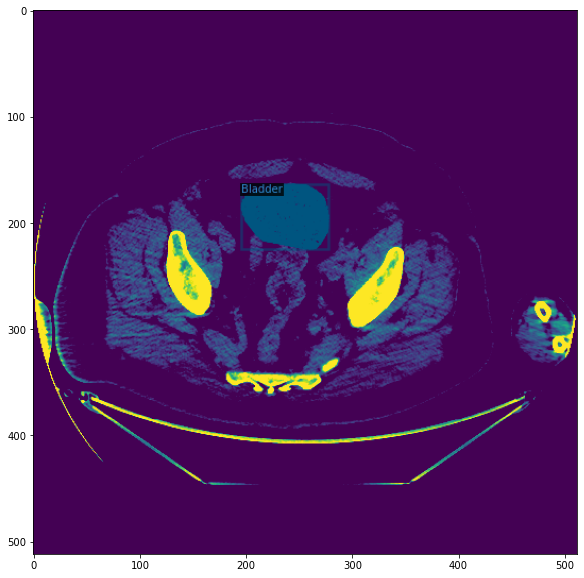

In [65]:
# visualize images + annotations from CT dataset
visualize_annotations(dicts_all['CT']['dicts'], dicts_all['CT']['metadata'], 1, True)

In [ ]:
# save datasets dict to disk
with open("detectron2_dict_PT.json", 'w') as f:
    json.dump(dicts_all['PT']['dicts'], f, indent=4)
    
with open("detectron2_dict_CT.json", 'w') as f:
    json.dump(dicts_all['CT']['dicts'], f, indent=4)

In [ ]:
# split data into train and test set based on patient id
# first get all patient ids
json_file = os.path.join("image_dataset/global_dict.json")
with open(json_file) as f:
    data = json.load(f)
all_patient_ids = list(data.keys())

splits = train_test_split(all_patient_ids, test_size=0.25, shuffle=True)

# generate dataset dicts
for i, phase in enumerate(["train", "test"]):
    print("Size of %s split: %i" % (phase, len(splits[i])))
    dataset_dicts = get_detectron2_dicts(img_dir, modality='PT',
                                         thing_classes={'Bladder':0}, patient_keys=splits[i])
    
    # save datasets dict to disk
    with open("detectron2_dict_PT_" + phase + ".json", 'w') as f:
        json.dump(dataset_dicts, f, indent=4)

In [ ]:
# check class histogram
# https://detectron2.readthedocs.io/en/latest/modules/data.html#detectron2.data.print_instances_class_histogram
# FIXME: nothing seems to happen
print_instances_class_histogram(dicts_all['CT']['dicts'], list(thing_classes_dict['CT'].keys()))